In [6]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [7]:
dataset = MNIST(root='data/', download=True)

In [8]:
len(dataset)
test_dataset = MNIST(root='data/', train=False)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# The statement %matplotlib inline indicates to Jupyter that we want to plot the graphs within the notebook 
# Without this line, Jupyter will show the image in a popup
# Statements starting with % are called magic commands and are used to configure the behavior of Jupyter

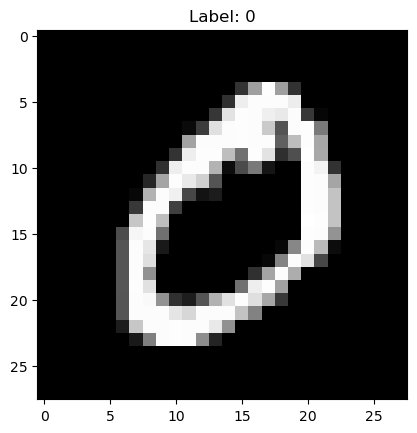

In [10]:
image, label = dataset[1]
plt.imshow(image,cmap='gray')
plt.title(f'Label: {label}')
plt.show() # add this explicitly as in some cases images are not rendered properly

In [11]:
import torchvision.transforms as tf

dataset = MNIST(root='data/', train=True, transform=tf.ToTensor())
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [12]:
from torch.utils.data import random_split, DataLoader

train_ds, val_ds = random_split(dataset, [50000, 10000])
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds,batch_size)

In [13]:
import torch.nn as nn

input_size = 28*28 # flattened into a single vector of size 1*28*28
num_classes = 10 # 0 to 9

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)

    def forward(self,xb):
        xb = xb.reshape(-1,784) #xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. 
                                #The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor
                                #So, shape will be set according to batch_size
        out = self.linear(xb) # inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear
        return out

model = MnistModel()

In [14]:
import torch.nn.functional as f    

In [16]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:3].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1459,  0.0217,  0.1107,  0.0104,  0.3223, -0.0826, -0.1476, -0.0193,
         -0.1949, -0.0720],
        [ 0.0763,  0.1721, -0.3078, -0.2575,  0.1289,  0.1627, -0.1528, -0.1002,
         -0.3358,  0.2394],
        [ 0.2473,  0.0181, -0.3621, -0.3191,  0.1429,  0.2731,  0.0815, -0.0797,
         -0.1471,  0.1295]])


In [17]:
probs = f.softmax(outputs,dim=1)
# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sum:  1.0000001192092896


In [19]:
# probs.shape
max_probs, preds = torch.max(probs,dim=1) # This is calculated for first batch only

In [20]:
def fit(epochs, lr, model, train_dl, val_dl, opt_fun=torch.optim.SGD):
    optimizer = opt_fun(model.parameters(), lr)
    history = [] # list which stores epoch-wise results

    for epoch in range(epochs):
        # Training
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation
        result = evaluate(model,val_dl)
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [22]:
def evaluate(model,val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # dim=1 means do this operation along specified dimension
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)

    def forward(self,xb):
        xb = xb.reshape(-1,784)
        out = self.linear(xb)
        return out

    def training_step(self,batch):
        images, labels = batch
        # When you call the model instance (self(images)), it internally invokes the forward method
        # If you directly call self.linear(images), you bypass any preprocessing (like reshaping) or additional layers/operations defined in the forward method
        out = self(images) 
        # softmax is not applied here because PyTorch's f.cross_entropy loss function already includes softmax internally
        loss = f.cross_entropy(out, labels)
        return loss

    def validation_step(self,batch):
        images, labels = batch
        out = self(images) # This basically holds the first return value among all methods defined in class
        loss = f.cross_entropy(out,labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # combine at the end of one epoch
        batch_accs = [y['val_acc'] for y in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [25]:
history1 = fit(8,0.001,model,train_dl,val_dl)

Epoch [0], val_loss: 1.2171, val_acc: 0.7913
Epoch [1], val_loss: 1.1247, val_acc: 0.8025
Epoch [2], val_loss: 1.0505, val_acc: 0.8115
Epoch [3], val_loss: 0.9898, val_acc: 0.8175
Epoch [4], val_loss: 0.9392, val_acc: 0.8230
Epoch [5], val_loss: 0.8964, val_acc: 0.8270
Epoch [6], val_loss: 0.8597, val_acc: 0.8319
Epoch [7], val_loss: 0.8279, val_acc: 0.8366


In [26]:
torch.save(model.state_dict(), 'mnist-logistic.pth')